In [1]:
import chardet

In [2]:
# Открываем файл в двоичном режиме и читаем данные
with open('/content/data.csv', 'rb') as file:
    raw_data = file.read()

In [3]:
# Используем chardet для определения кодировки
result = chardet.detect(raw_data)

In [4]:
# Получаем название кодировки
encoding_file = result['encoding']

In [5]:
print(f"Кодировка файла: {encoding_file}")

Кодировка файла: ISO-8859-1


#Загружаем библиотеки

In [42]:
from keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.graph_objects as go

#Готовим данные

In [7]:
# Загрузка данных
data = pd.read_csv('/content/data.csv', encoding=encoding_file, delimiter=';')

In [8]:
# Проверка на наличие пустых значений
print(data.isnull().sum())

Datetime             0
Radon (Bq.m3)        9
Temperature (¡C)    55
Pressure (mBar)      0
dtype: int64


In [9]:
# Получение информации о DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8762 entries, 0 to 8761
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Datetime          8762 non-null   object 
 1   Radon (Bq.m3)     8753 non-null   float64
 2   Temperature (¡C)  8707 non-null   object 
 3   Pressure (mBar)   8762 non-null   object 
dtypes: float64(1), object(3)
memory usage: 273.9+ KB


In [10]:
data['Temperature (¡C)'] = data['Temperature (¡C)'].str.replace(',', '.').astype(float)

In [11]:
data['Pressure (mBar)'] = data['Pressure (mBar)'].str.replace(',', '.').astype(float)

In [12]:
# Замена пустых значений средними по каждому столбцу
for column in data.columns:
    # Проверяем, содержит ли столбец числовые данные
    if pd.api.types.is_numeric_dtype(data[column]):
        # Заменяем пустые значения средними, только если столбец числовой
        data[column].fillna(data[column].mean(), inplace=True)
    else:
        # Если столбец не числовой, можно заменить пустые значения другим способом
        # Например, можно использовать наиболее часто встречающееся значение:
        # data[column].fillna(data[column].mode()[0], inplace=True)
        pass  # или пропустить столбец

In [13]:
# Проверка на наличие пустых значений
print(data.isnull().sum())

Datetime            0
Radon (Bq.m3)       0
Temperature (¡C)    0
Pressure (mBar)     0
dtype: int64


In [14]:
data.columns

Index(['Datetime', 'Radon (Bq.m3)', 'Temperature (¡C)', 'Pressure (mBar)'], dtype='object')

In [15]:
data.head()

,Datetime,Radon (Bq.m3),Temperature (¡C),Pressure (mBar)
0,04.05.2020 17:00,22204.0,2.027428,981.284980
1,04.05.2020 18:00,25594.0,0.615326,980.457186
2,04.05.2020 19:00,22204.0,0.113435,980.125557
3,04.05.2020 20:00,23617.0,-0.093737,980.157554
4,04.05.2020 21:00,21357.0,-0.191938,980.463049


In [16]:
# Преобразование столбца с датой и временем в формат datetime
data['Datetime'] = pd.to_datetime(data['Datetime'], format='%d.%m.%Y %H:%M')

In [17]:
# Установка столбца с датой и временем в качестве индекса
data.set_index('Datetime', inplace=True)


In [18]:
# Разделение данных на наборы
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

In [19]:
# Нормализация данных
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [20]:
# Создание датасета для обучения RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0]) # Предсказываем только уровень радона
    return np.array(dataX), np.array(dataY)

In [21]:
time_step = 5
X_train, y_train = create_dataset(train_scaled, time_step)

In [22]:
time_step = 5
X_val, y_val = create_dataset(val_scaled, time_step)

In [23]:
time_step = 5
X_test, y_test = create_dataset(test_scaled, time_step)

In [24]:
# Изменение формы входных данных для модели RNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], data.shape[1])


In [25]:
# Изменение формы входных данных для модели RNN
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], data.shape[1])

In [26]:
# Изменение формы входных данных для модели RNN
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], data.shape[1])

In [27]:
# Загрузка моделей
model_names = ['bidirectional.h5', 'deep_rnn.h5', 'lstm.h5', 'gru.h5', 'rnn.h5']
models = {name: load_model('/content/models/' + name) for name in model_names}

In [28]:
# Сравнение моделей
metrics_dict = {}

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Вычисление метрик
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Сохранение метрик в словаре
    metrics_dict[name] = {'MSE': mse, 'MAE': mae, 'R^2': r2}

# Теперь metrics_dict содержит метрики для каждой модели
print(metrics_dict)

28/28 [==============================] - 1s 5ms/step
{'bidirectional.h5': {'MSE': 0.05294775302516468, 'MAE': 0.19263846408028926, 'R^2': -0.034684650184166}, 'deep_rnn.h5': {'MSE': 0.05137153502765596, 'MAE': 0.1857999200345949, 'R^2': -0.0038828035677251904}, 'lstm.h5': {'MSE': 0.05119152554447889, 'MAE': 0.17940567138555258, 'R^2': -0.00036512739660654603}, 'gru.h5': {'MSE': 0.05226286096309374, 'MAE': 0.19028658310595792, 'R^2': -0.021300752602695594}, 'rnn.h5': {'MSE': 0.055226421351292694, 'MAE': 0.20213118106408098, 'R^2': -0.07921351128210419}}


In [29]:
# Преобразование словаря в DataFrame
metrics_df = pd.DataFrame(metrics_dict)

# Вывод DataFrame
print(metrics_df)

     bidirectional.h5  deep_rnn.h5   lstm.h5    gru.h5    rnn.h5
MSE          0.052948     0.051372  0.051192  0.052263  0.055226
MAE          0.192638     0.185800  0.179406  0.190287  0.202131
R^2         -0.034685    -0.003883 -0.000365 -0.021301 -0.079214


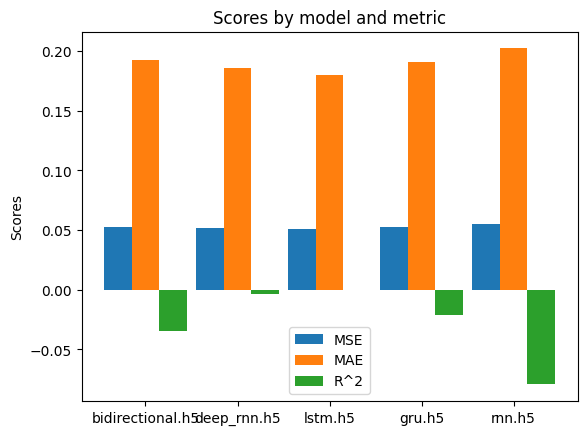

In [30]:
# Создание столбчатой диаграммы
labels = list(metrics_dict.keys())
mse_values = [metrics['MSE'] for metrics in metrics_dict.values()]
mae_values = [metrics['MAE'] for metrics in metrics_dict.values()]
r2_values = [metrics['R^2'] for metrics in metrics_dict.values()]

x = np.arange(len(labels))  # местоположение меток
width = 0.3  # ширина столбцов

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mse_values, width, label='MSE')
rects2 = ax.bar(x, mae_values, width, label='MAE')
rects3 = ax.bar(x + width, r2_values, width, label='R^2')

# Добавление меток, названия и пользовательских меток осей X
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Вывод диаграммы
plt.show()

In [32]:
history_names = ['bidirectional_history', 'deep_rnn_history', 'gru_history', 'lstm_history', 'rnn_history']

In [35]:
# Загрузка историй обучения
history_dict = {}
for name in history_names:
    with open(f'/content/history/{name}.pkl', 'rb') as f:
        history_dict[name] = pickle.load(f)

# Теперь history_dict содержит историю обучения для каждой модели
print(history_dict)

{'bidirectional_history': {'loss': [0.06962651759386063, 0.057533033192157745, 0.05623428151011467, 0.055360473692417145, 0.054970722645521164, 0.054372984915971756, 0.05392514541745186, 0.05364210903644562, 0.053391605615615845, 0.05337882041931152, 0.05318327993154526, 0.053200703114271164, 0.05302288010716438, 0.052935659885406494, 0.05303070321679115, 0.05296792834997177, 0.052891988307237625, 0.05274726450443268, 0.05285244435071945, 0.0528377927839756], 'val_loss': [0.0534311980009079, 0.05536402016878128, 0.052736639976501465, 0.054801344871520996, 0.05246616154909134, 0.05246829614043236, 0.05113009363412857, 0.05173565819859505, 0.05324849113821983, 0.051542557775974274, 0.052487827837467194, 0.053197573870420456, 0.05486229434609413, 0.05128030851483345, 0.05183349922299385, 0.052923038601875305, 0.051284804940223694, 0.0513935387134552, 0.05296780914068222, 0.052518635988235474]}, 'deep_rnn_history': {'loss': [0.07770774513483047, 0.06694457679986954, 0.06253065168857574, 0.

In [37]:
# Преобразование словаря в DataFrame
history_df = pd.DataFrame(history_dict)

# Вывод DataFrame
print(history_df)

                                      bidirectional_history  \
loss      [0.06962651759386063, 0.057533033192157745, 0....   
val_loss  [0.0534311980009079, 0.05536402016878128, 0.05...   

                                           deep_rnn_history  \
loss      [0.07770774513483047, 0.06694457679986954, 0.0...   
val_loss  [0.05658339336514473, 0.05152575671672821, 0.0...   

                                                gru_history  \
loss      [0.05467241257429123, 0.05332585424184799, 0.0...   
val_loss  [0.05160224065184593, 0.05131472274661064, 0.0...   

                                               lstm_history  \
loss      [0.05330118164420128, 0.05278681963682175, 0.0...   
val_loss  [0.051273245364427567, 0.05121387541294098, 0....   

                                                rnn_history  
loss      [0.06417403370141983, 0.054773397743701935, 0....  
val_loss  [0.054885897785425186, 0.05258394777774811, 0....  


In [44]:
# Создание отдельного графика для каждой модели
fig = go.Figure()

for name, history in history_dict.items():
    fig.add_trace(go.Scatter(
        x=list(range(1, len(history['val_loss']) + 1)),
        y=history['val_loss'],
        mode='lines+markers',
        name=name
    ))

# Настройка параметров графика
fig.update_layout(
    title='Validation Loss over Epochs',
    xaxis=dict(title='Epochs'),
    yaxis=dict(title='Validation Loss'),
    hovermode='x',
    # Добавление легенды с возможностью отключения линий
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.57,
            y=1.2,
            buttons=list([
                dict(label="All",
                     method="update",
                     args=[{"visible": [True, True, True, True, True]}]),
                dict(label="None",
                     method="update",
                     args=[{"visible": [False, False, False, False, False]}]),
                dict(label="Bidirectional",
                     method="update",
                     args=[{"visible": [True, False, False, False, False]}]),
                dict(label="Deep RNN",
                     method="update",
                     args=[{"visible": [False, True, False, False, False]}]),
                dict(label="LSTM",
                     method="update",
                     args=[{"visible": [False, False, True, False, False]}]),
                dict(label="GRU",
                     method="update",
                     args=[{"visible": [False, False, False, True, False]}]),
                dict(label="RNN",
                     method="update",
                     args=[{"visible": [False, False, False, False, True]}]),
            ]),
        )
    ]
)

# Отображение графика
fig.show()
